In [ ]:
!python --version

Python 3.6.9


In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Thesis/Attack\ Step\ Prediction/Implementation
!ls

/content/drive/MyDrive/Thesis/Attack Step Prediction/Implementation
APTGen_json	 __pycache__	test_data_sequence.txt
aptgen_utils.py  sequences.csv	unique_steps.txt


In [ ]:
import tensorflow as tf
import numpy as np
import random
import csv

import aptgen_utils

In [ ]:
# to reflect the changes, the module needs to be reloaded
import importlib
importlib.reload(aptgen_utils)

<module 'aptgen_utils' from '/content/drive/My Drive/Thesis/Attack Step Prediction/Implementation/aptgen_utils.py'>

In [ ]:
dir(aptgen_utils)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'csv',
 'get_conversion_dicts',
 'get_data_text',
 'get_train_test_data',
 'sequence_to_indices']

<font size=5>***Indexing starts from 1***</font>

In [ ]:
step_to_index, index_to_step = aptgen_utils.get_conversion_dicts()
# indexing starts from 1
step_to_index['discovery TA0007 Account_Discovery T1087']

16

# Experiment 1:
We'll take *80 samples from each 100* attack sequence as training data and rest of the samples will go as test data. As each 100 sequence belong to a particular incident, we are doing a 80-20 split from each incident. Our goal here is to see how combined information from all incidents together help in prediction.

Training data: `80 * 8` = `640` samples

Testing data: `20 * 8` = `160` samples

In [ ]:
# get attack sequences as list of lists
data_text = aptgen_utils.get_data_text()
print(data_text[0])
len(data_text)

['collection TA0009 Email_Collection T1114', 'credential_access TA0006 Credential_Dumping T1003', 'discovery TA0007 System_Information_Discovery T1082', 'collection TA0009 Email_Collection T1114', 'defense_evasion TA0005 File_Deletion T1107', 'persistence TA0003 Scheduled_Task T1053', 'discovery TA0007 System_Information_Discovery T1082', 'collection TA0009 Email_Collection T1114']


800

In [ ]:
# convert the sequences to a list of indices
data_indices = aptgen_utils.sequence_to_indices(data_text, step_to_index)
print(data_indices[0])
len(data_indices)

[2, 5, 24, 2, 12, 47, 24, 2]


800

Now our goal is to divide the data into train and test sets in way that maintains the distribution of different steps. That means, both train and test data should have samples representing each steps. 

For example, there are 50 unique steps in the whole dataset. So, labels in the both train and test set should have those 50 steps and also they should be distributed according to 80-20 split. If step_2 occurs 100 times in the labels of an incident then 80 samples from them will go to training set and rest 20 will go to test set.

Now, we'll check the frequency count of the last steps in the sequences belonging to each incident.

In [ ]:
last_steps = []
for sequence in data_indices:
    last_steps.append(sequence[-1])

In [ ]:
from collections import Counter
print("Number of unique target labels:", len(Counter(last_steps).keys()))
counter = Counter(last_steps)
print(counter)

Number of unique target labels: 36
Counter({32: 272, 12: 142, 36: 127, 14: 47, 11: 46, 37: 26, 35: 24, 30: 13, 34: 12, 5: 12, 33: 12, 22: 8, 1: 8, 2: 7, 3: 6, 17: 5, 24: 3, 13: 3, 4: 3, 23: 2, 31: 2, 45: 2, 6: 2, 47: 2, 9: 2, 26: 2, 20: 1, 7: 1, 25: 1, 27: 1, 46: 1, 21: 1, 29: 1, 19: 1, 41: 1, 16: 1})


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


<StemContainer object of 3 artists>

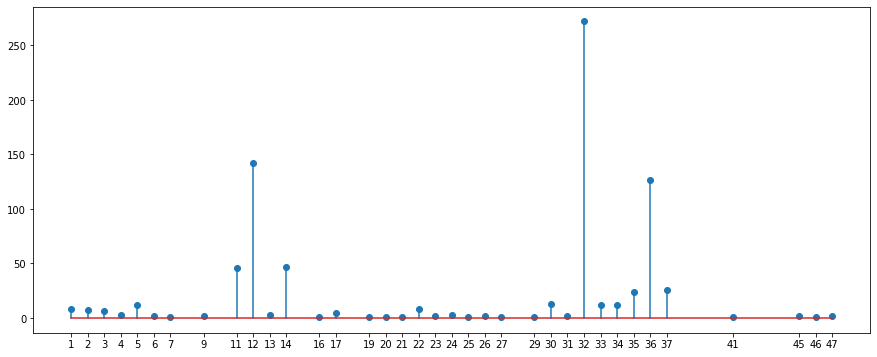

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
x = [key for key in counter.keys()]
y = [val for val in counter.values()]

plt.xticks(x)
plt.stem(x, y)

In [ ]:
unit_steps = [20, 7, 25, 27, 46, 21, 29, 19, 41, 16]
for step in unit_steps:
    print(index_to_step[step])

discovery TA0007 Permission_Groups_Discovery T1069
credential_access TA0006 Credentials_in_Registry T1214
discovery TA0007 System_Network_Configuration_Discovery T1016
discovery TA0007 System_Owner/User_Discovery T1033
persistence TA0003 Registry_Run_Keys_/_Startup_Folder T1060
discovery TA0007 Query_Registry T1012
discovery TA0007 System_Time_Discovery T1124
discovery TA0007 Password_Policy_Discovery T1201
persistence TA0003 Hooking T1179
discovery TA0007 Account_Discovery T1087


In [ ]:
index_of_samples_by_labels = {}
for idx, sequence in enumerate(data_indices):
    if sequence[-1] in index_of_samples_by_labels:
        index_of_samples_by_labels[sequence[-1]].append(idx)
    else:
        index_of_samples_by_labels[sequence[-1]] = [idx]

print("samples with target label 2 (before shuffling):", index_of_samples_by_labels[2])

# As there are 10 labels which only have 1 sample, we'll remove them from our data.
sample_indices_to_remove = []
for idx, step in enumerate(last_steps):
    if step in unit_steps:
        sample_indices_to_remove.append(idx)
print("sample indices corresponding to unit target labels", sample_indices_to_remove)


# remove keys that only have one samples
for key in unit_steps:
    index_of_samples_by_labels.pop(key, None)
print("After removing target labels with only one samples,", index_of_samples_by_labels.keys())

# we'll shuffle the sample indices inside the dict
for key in index_of_samples_by_labels.keys():
    rand = random.Random(69)
    rand.shuffle(index_of_samples_by_labels[key])
print("samples with target label 2 (after shuffling):", index_of_samples_by_labels[2])

samples with target label 2 (before shuffling): [0, 1, 6, 300, 302, 312, 313]
sample indices corresponding to unit target labels [3, 10, 18, 105, 208, 318, 319, 643, 644, 701]
After removing target labels with only one samples, dict_keys([2, 12, 22, 1, 24, 17, 36, 34, 32, 23, 31, 11, 45, 5, 13, 3, 4, 6, 35, 14, 33, 37, 30, 47, 9, 26])
samples with target label 2 (after shuffling): [6, 300, 302, 1, 313, 0, 312]


In [ ]:
print("Number of target labels:", len(index_of_samples_by_labels.keys()))

Number of target labels: 26


Now we'll distribute the train and test data indices according to the label frequency. As an example, of the labels having 2 samples, one will go to train set and antother to test set.

In [ ]:
#{32: 272, 12: 142, 36: 127, 14: 47, 11: 46, 37: 26, 35: 24, 30: 13, 34: 12, 5: 12, 33: 12, 22: 8, 1: 8, 2: 7, 3: 6, 17: 5, 24: 3, 13: 3, 4: 3, 23: 2, 31: 2, 45: 2, 6: 2, 47: 2, 9: 2, 26: 2}
# the keys are the target labels 
# the values are the number of samples that will go to train set wchich have the key as the target label 
train_distribution = {23: 1, 31: 1, 45: 1, 6: 1, 47: 1, 9: 1, 26: 1, 24: 2, 13: 2, 4: 2, 17: 3, 3: 4, 2: 5, 1: 6, 22: 6, 33: 9, 5: 9, 34: 9, 30: 10, 35: 19, 37: 20, 11: 37, 14: 38, 36: 110, 12: 117, 32: 225}

train_indices = []
test_indices = []
for key in train_distribution.keys():
    sample_count = train_distribution[key]
    train_indices.extend(index_of_samples_by_labels[key][:sample_count])
    test_indices.extend(index_of_samples_by_labels[key][sample_count:])

In [ ]:
print("Number of train samples:", len(train_indices))
print("Number of test samples:", len(test_indices))

Number of train samples: 640
Number of test samples: 150


In [ ]:
for i in range(8):
    curr_range = i * 100
    num_of_indices = len([x for x in train_indices if x >= curr_range and x < curr_range + 100])
    print(f"Train samples from incident {i+1}:", num_of_indices)

Train samples from incident 1: 76
Train samples from incident 2: 82
Train samples from incident 3: 81
Train samples from incident 4: 77
Train samples from incident 5: 86
Train samples from incident 6: 81
Train samples from incident 7: 76
Train samples from incident 8: 81


In [ ]:
for i in range(8):
    curr_range = i * 100
    num_of_indices = len([x for x in test_indices if x >= curr_range and x < curr_range + 100])
    print(f"Test samples from incident {i+1}:", num_of_indices)

Test samples from incident 1: 21
Test samples from incident 2: 17
Test samples from incident 3: 18
Test samples from incident 4: 21
Test samples from incident 5: 14
Test samples from incident 6: 19
Test samples from incident 7: 22
Test samples from incident 8: 18


In [ ]:
train_data_sequence, test_data_sequence = aptgen_utils.get_train_test_data(train_indices, test_indices)

In [ ]:
len(train_data_sequence)

640

In [ ]:
# with open("test_data_sequence.txt", "w") as f:
#     for sequence in test_data_sequence:
#         for step in sequence:
#             f.write(step)
#             f.write(",")
#         f.write("\n")

<font size=4>In this experiment, we'll consider the **last step** in each attack sequence as the <font color="green">*step to be predicted*</font>. Thus, from each attack sequence, we'll take the last step in the sequence as `Y` and the former steps as `X`.</font>

<font size=4> Now, we'll convert steps in each attack sequence to indices. As our samples (attack sequences) are <font size=5>*variable in length*</font>, we'll zero pad them with the length of the longest sample. So, all the samples will have `max_len-1 = 35-1 = 34` steps because we'll be taking out the last step as the `label`.</font>

In [ ]:
def sequence_to_indices(data_sequence):
    max_sequence_len = 35
    data_index = np.zeros((len(data_sequence), max_sequence_len-1))

    for i in range(len(data_sequence)):
        steps = data_sequence[i]
        for j in range(len(steps) - 1): # loop will stop just before the last step
            step = steps[j]
            data_index[i, j] = step_to_index[step]

    return data_index

In [ ]:
# convert steps to corresponding indices which will later be used for one_hot encoding
train_data_index = sequence_to_indices(train_data_sequence)
test_data_index = sequence_to_indices(test_data_sequence)

In [ ]:
len(train_data_index[69])

34

In [ ]:
len(test_data_index[69])

34

In [ ]:
# get X_train, X_test from train and test data index
X_train, X_test = train_data_index, test_data_index

We'll take out the last step before padding as the step to be predicted or the label.

In [ ]:
# get Y labels from data_sequence
Y_train = []
Y_test = []
for i in range(len(train_data_sequence)):
    last_step_index = step_to_index[train_data_sequence[i][-1]]
    Y_train.append(last_step_index)

for i in range(len(test_data_sequence)):
    last_step_index = step_to_index[test_data_sequence[i][-1]]
    Y_test.append(last_step_index)

Y_train = np.asarray(Y_train, dtype=np.float32)
Y_test = np.asarray(Y_test, dtype=np.float32)

In [ ]:
print("Sample X_train: (X_train[0])=", X_train[0])
print("Sample Y_train: (Y_train[0])=", Y_train[0])
print("Sample X_test: (X_test[0])=", X_test[0])
print("Sample Y_test: (Y_test[0])=", Y_test[0])
print()
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Sample X_train: (X_train[0])= [ 1. 47.  5. 32. 18. 12.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Sample Y_train: (Y_train[0])= 2.0
Sample X_test: (X_test[0])= [ 2.  5. 24.  2. 12. 47. 24.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Sample Y_test: (Y_test[0])= 2.0

X_train shape: (640, 34)
Y_train shape: (640,)
X_test shape: (150, 34)
Y_test shape: (150,)


In [ ]:
print("Number of unique steps in X_train:", len(np.unique(X_train)))
print("Number of unique steps in Y_train:", len(np.unique(Y_train)))
print("Number of unique steps in X_test:", len(np.unique(X_test)))
print("Number of unique steps in Y_test:", len(np.unique(Y_test)))

Number of unique steps in X_train: 51
Number of unique steps in Y_train: 26
Number of unique steps in X_test: 51
Number of unique steps in Y_test: 26


In [ ]:
np.unique(X_train, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 array([13654,   687,   268,   342,    52,   838,   198,   151,    28,
          218,    77,   482,   532,    79,   193,    54,   127,   653,
           85,    47,    35,   103,   598,    59,    93,   128,    40,
           25,    93,   198,    39,    38,   276,    45,    52,   114,
          283,    22,    24,    35,    42,    25,    40,    52,    28,
          187,    41,   152,    29,    45,    54]))

<font size=4>Now, we'll convert X_train, X_test, Y_train and Y_test to 2D one_hot vectors.</font>

In [ ]:
unique_steps = 50
unique_target_labels = 26
X_train_oh = tf.one_hot(X_train, unique_steps + 1).numpy() # +1 for 0s (were added for padding)
Y_train_oh = tf.one_hot(Y_train, unique_target_labels).numpy() # number of labels = number of unique steps (no 0s like train data)
X_test_oh = tf.one_hot(X_test, unique_steps + 1).numpy()
Y_test_oh = tf.one_hot(Y_test, unique_target_labels).numpy()
print("X_train_oh shape:", X_train_oh.shape)
print("Y_train_oh shape:", Y_train_oh.shape)
print("X_test_oh shape:", X_test_oh.shape)
print("Y_test_oh shape:", Y_test_oh.shape)

X_train_oh shape: (640, 34, 51)
Y_train_oh shape: (640, 26)
X_test_oh shape: (150, 34, 51)
Y_test_oh shape: (150, 26)


Zero out the first column of all onehot sequence. These rows correspond to the padded zero value. This is done to let the LSTM layers ignore these sequences while doing computation.

In [ ]:
X_train_oh[:, :, 0] = 0
X_test_oh[:, :, 0] = 0
Y_train_oh[:, 0] = 0  
Y_test_oh[:, 0] = 0

with np.printoptions(threshold=2000):
     print(X_train_oh[0, :, :])

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

The masking layer produces a <font size=5>boolean tensor</font> from the input tensor that denotes which inputs are to be considered and which are to be ignored. This tensor is automatically propagated to the next layers.

In [ ]:
from tensorflow.keras import Model, layers
padded_inputs = X_train_oh[0, :, :]
masked_output = layers.Masking(mask_value=0.0)(padded_inputs)

print(masked_output._keras_mask)

tf.Tensor(
[ True  True  True  True  True  True  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False], shape=(34,), dtype=bool)


In [ ]:
timesteps = 34 # number of steps in each sample
vocab_size = 51 # number of unique steps(including 0)

Now, we'll make the model.

In [ ]:
# using embedding layer
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K 

K.clear_session()
inputs = layers.Input(shape=(timesteps, vocab_size))
# X = layers.Embedding(input_dim=vocab_size, output_dim=16, mask_zero=True)(inputs) # vocab_size is including 0
X = layers.Masking(mask_value=0.0)(inputs)
X = layers.Dense(units=512)(X)
#X = layers.Dropout(0.2)(masked_inputs)
X, h_state, c_state = layers.LSTM(units=2048, return_sequences=True, return_state=True)(X)
X, h_state, c_state = layers.LSTM(units=2048, return_sequences=True, return_state=True)(X, initial_state=[h_state, c_state])
X = layers.LSTM(units=2048, return_sequences=True)(X, initial_state=[h_state, c_state])
X = layers.Flatten()(X)
#X = layers.LSTM(units=64)(X)
X = layers.Dense(units=1024, activation='relu')(X)
X = layers.Dense(units=1024, activation='relu')(X)
X = layers.Dense(units=512, activation='relu')(X)
X = layers.Dense(units=512, activation='relu')(X)
X = layers.Dense(units=256, activation='relu')(X)
X = layers.Dense(units=256, activation='relu')(X)
# X = layers.Dropout(0.2)(X)
# Propagate X through a Dense layer with 26 units
outputs = layers.Dense(units=26, activation='softmax')(X)
# outputs = layers.Activation("softmax")(X)
model_emb = Model(inputs=inputs, outputs=outputs, name="Experiment_2")

model_emb.summary()

Model: "Experiment_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 34, 51)]     0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 34, 51)       0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 34, 512)      26624       masking[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 34, 2048), ( 20979712    dense[0][0]                      
_______________________________________________________________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam
adam = Adam(lr=1e-6)
model_emb.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
history = model_emb.fit(X_train_oh, Y_train_oh, epochs=200, batch_size=16, validation_data=(X_test_oh, Y_test_oh), shuffle=True)

Epoch 1/200
40/40 [==============================] - 17s 212ms/step - loss: 1.1647 - accuracy: 0.0542 - val_loss: 1.3463 - val_accuracy: 0.1867
Epoch 2/200
40/40 [==============================] - 4s 105ms/step - loss: 1.1395 - accuracy: 0.1938 - val_loss: 1.3458 - val_accuracy: 0.1667
Epoch 3/200
40/40 [==============================] - 4s 107ms/step - loss: 1.2603 - accuracy: 0.2008 - val_loss: 1.3447 - val_accuracy: 0.1667
Epoch 4/200
40/40 [==============================] - 4s 106ms/step - loss: 1.1931 - accuracy: 0.1818 - val_loss: 1.3422 - val_accuracy: 0.1667
Epoch 5/200
40/40 [==============================] - 4s 106ms/step - loss: 1.2049 - accuracy: 0.1812 - val_loss: 1.3349 - val_accuracy: 0.1667
Epoch 6/200
40/40 [==============================] - 4s 108ms/step - loss: 1.0521 - accuracy: 0.1589 - val_loss: 1.3098 - val_accuracy: 0.1667
Epoch 7/200
40/40 [==============================] - 4s 106ms/step - loss: 1.1742 - accuracy: 0.1853 - val_loss: 1.2081 - val_accuracy: 0.166

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

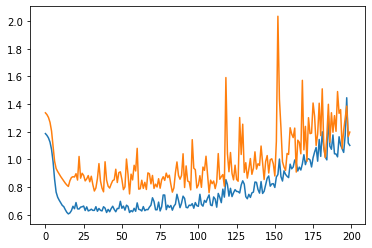

In [ ]:
# code for plotting metrics
from matplotlib import pyplot

# history = model.fit(X, X, epochs=500, batch_size=len(X), verbose=2)
# plot metrics
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.show()

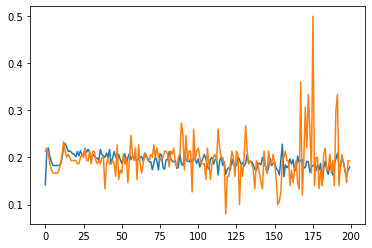

In [ ]:
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.show()